In [1]:
from glob import glob

import warnings
warnings.filterwarnings('ignore') # :clown:

In [2]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
files = glob('../data/ecg_preprocessed/*.csv')

In [6]:
df = pd.read_csv(files[0])
df.head()

,timestamp,signal,signal_normalised,subject_id,category,code,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,...,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,2017-12-15 10:16:06+00:00,-0.000073,0.493088,30100,NaN,NaN,-0.000073,-0.000095,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,2017-12-15 10:16:06.001000+00:00,-0.000083,0.492200,30100,NaN,NaN,-0.000083,-0.000097,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,2017-12-15 10:16:06.002000+00:00,-0.000095,0.491090,30100,NaN,NaN,-0.000095,-0.000100,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,2017-12-15 10:16:06.003000+00:00,-0.000103,0.490368,30100,NaN,NaN,-0.000103,-0.000102,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,2017-12-15 10:16:06.004000+00:00,-0.000110,0.489757,30100,NaN,NaN,-0.000110,-0.000105,64.763176,0.998214,...,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [9]:
sample = df[:1000 * 5]['signal']

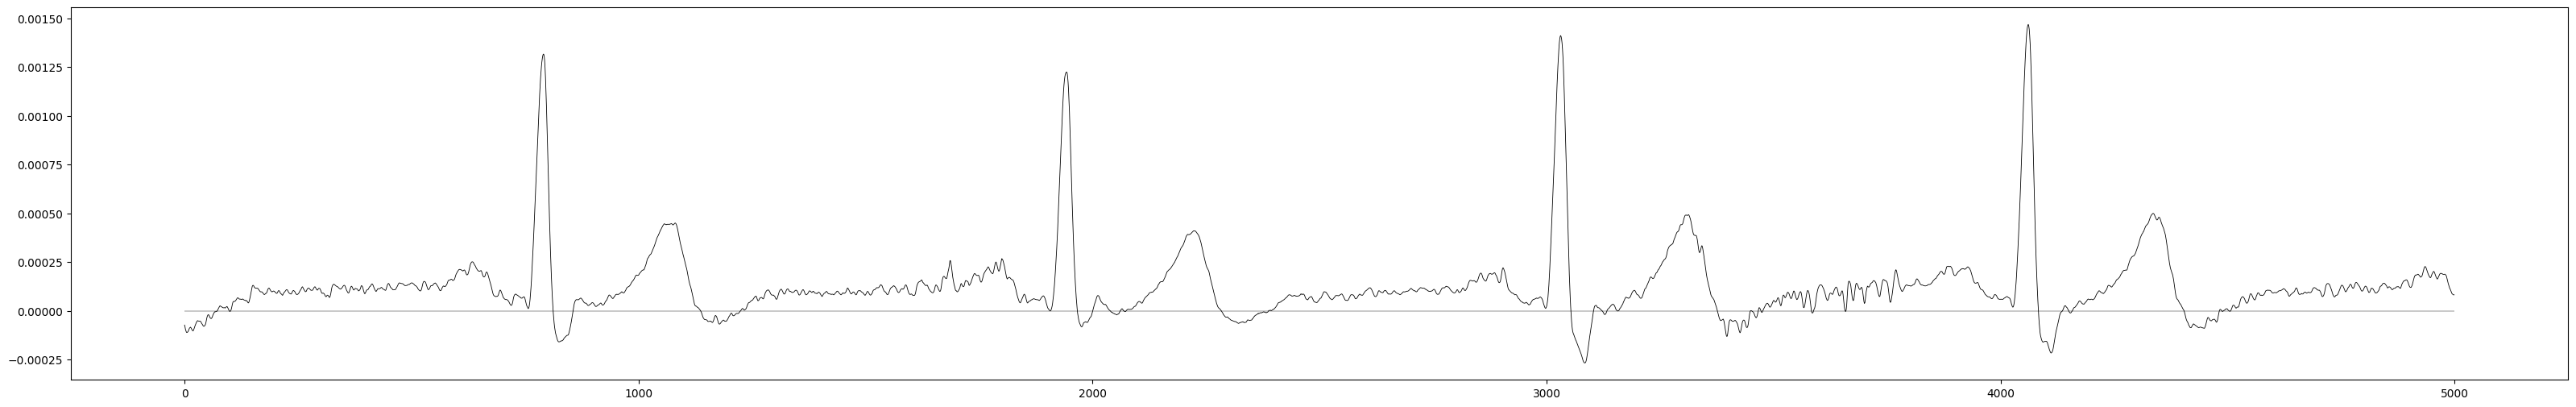

In [10]:
plt.figure(figsize=(40,6))
plt.plot(sample, color='black', linewidth=0.6)
plt.hlines(0,0,5000,color='black', linewidth=0.3)

## Bior4.4 Wavelet Transform
From https://www.kaggle.com/code/nelsonsharma/ecg-02-ecg-signal-pre-processing

In [8]:
import pywt
from pywt import wavedec

In [11]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
        
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])

    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    
    return Y  


signal_den = denoise_signal(sample,'bior4.4', 9 , 1 , 7) #<--- trade off - the less the cutoff - th

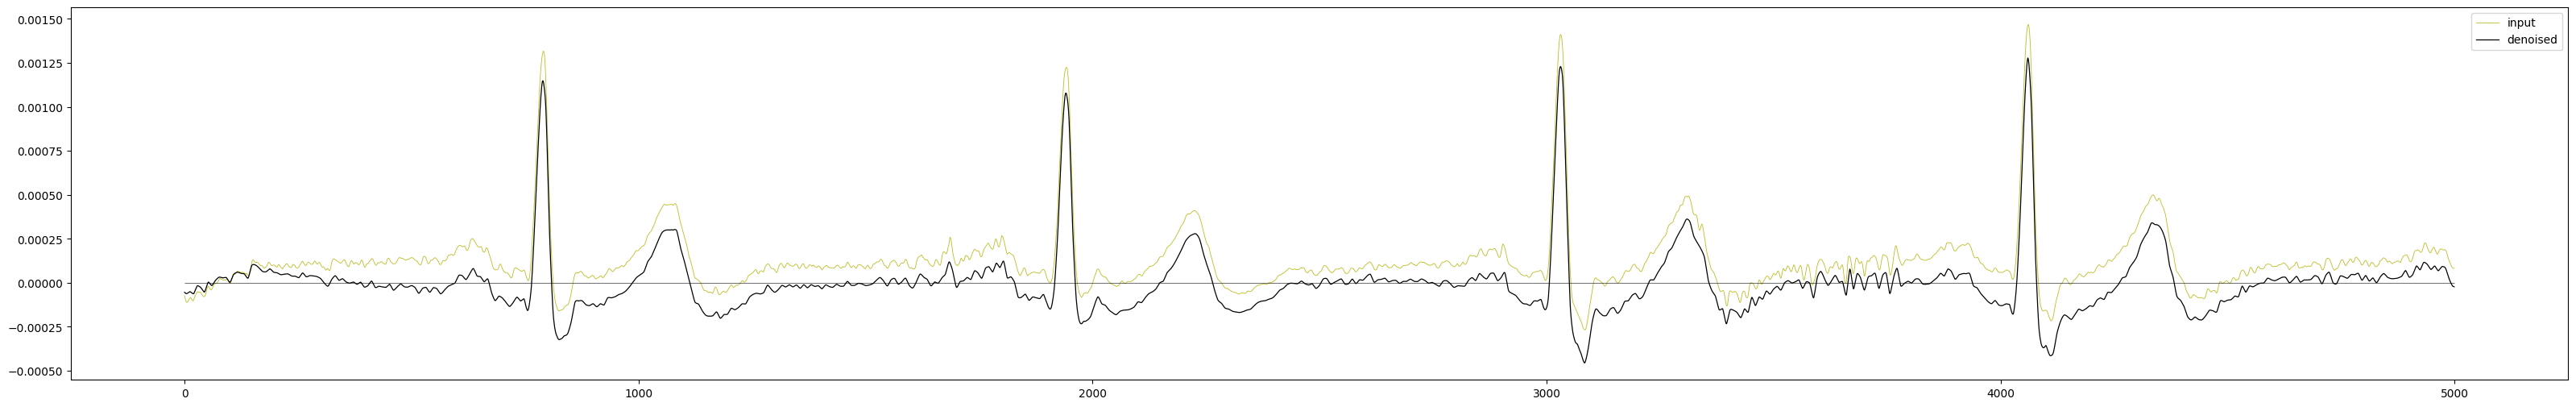

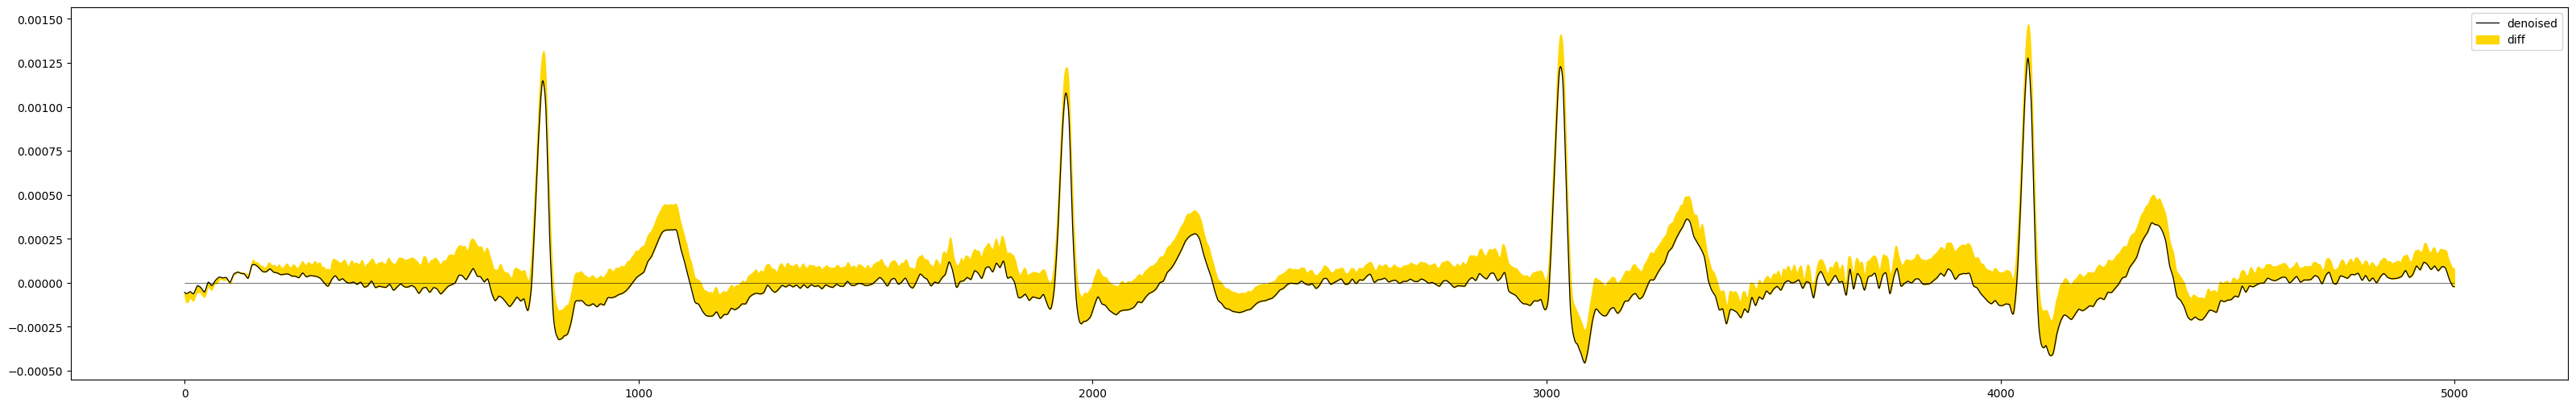

In [12]:
plt.figure(figsize=(40,6))

plt.plot(sample, color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.fill_between(np.arange(0,5000,1),sample,signal_den,color='gold',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

## Remove Baseline Wander
From https://www.kaggle.com/code/nelsonsharma/ecg-02-ecg-signal-pre-processing

In [13]:
from scipy.signal import medfilt

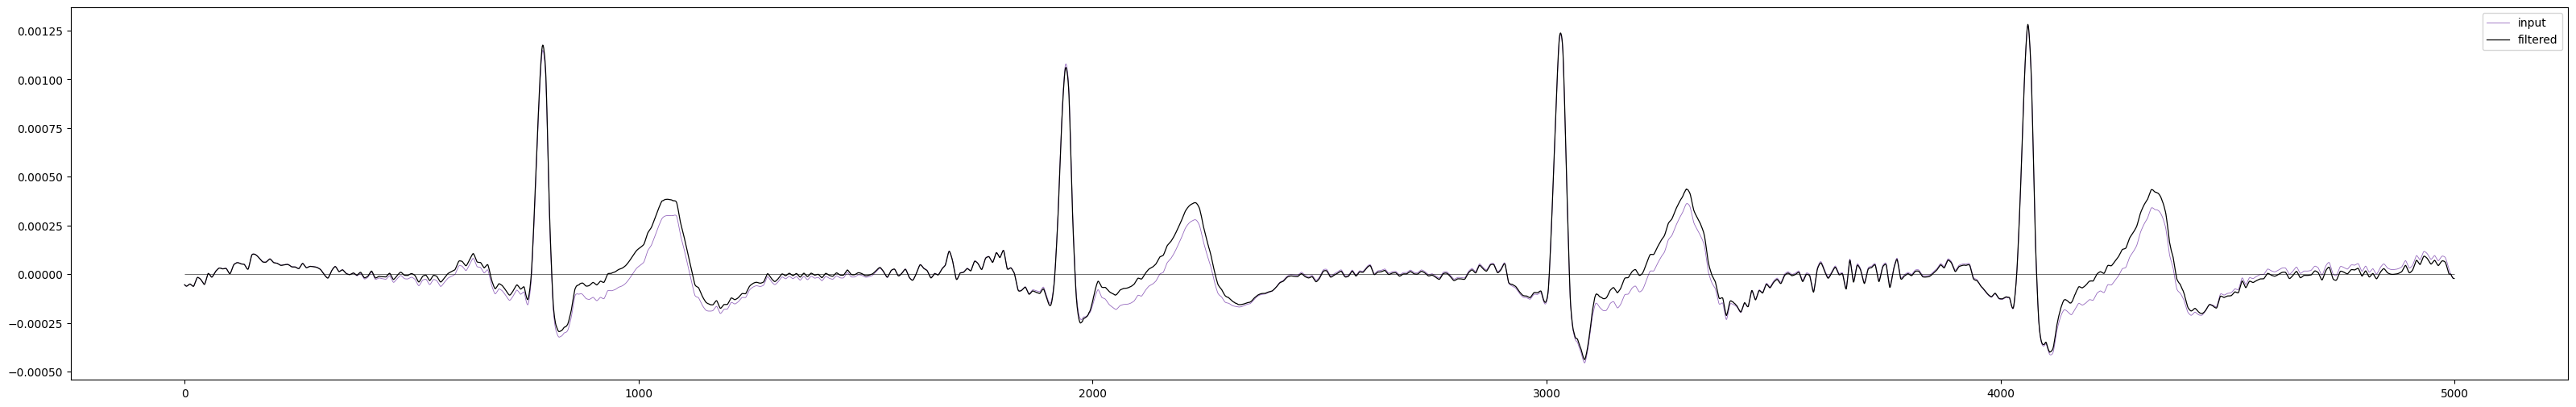

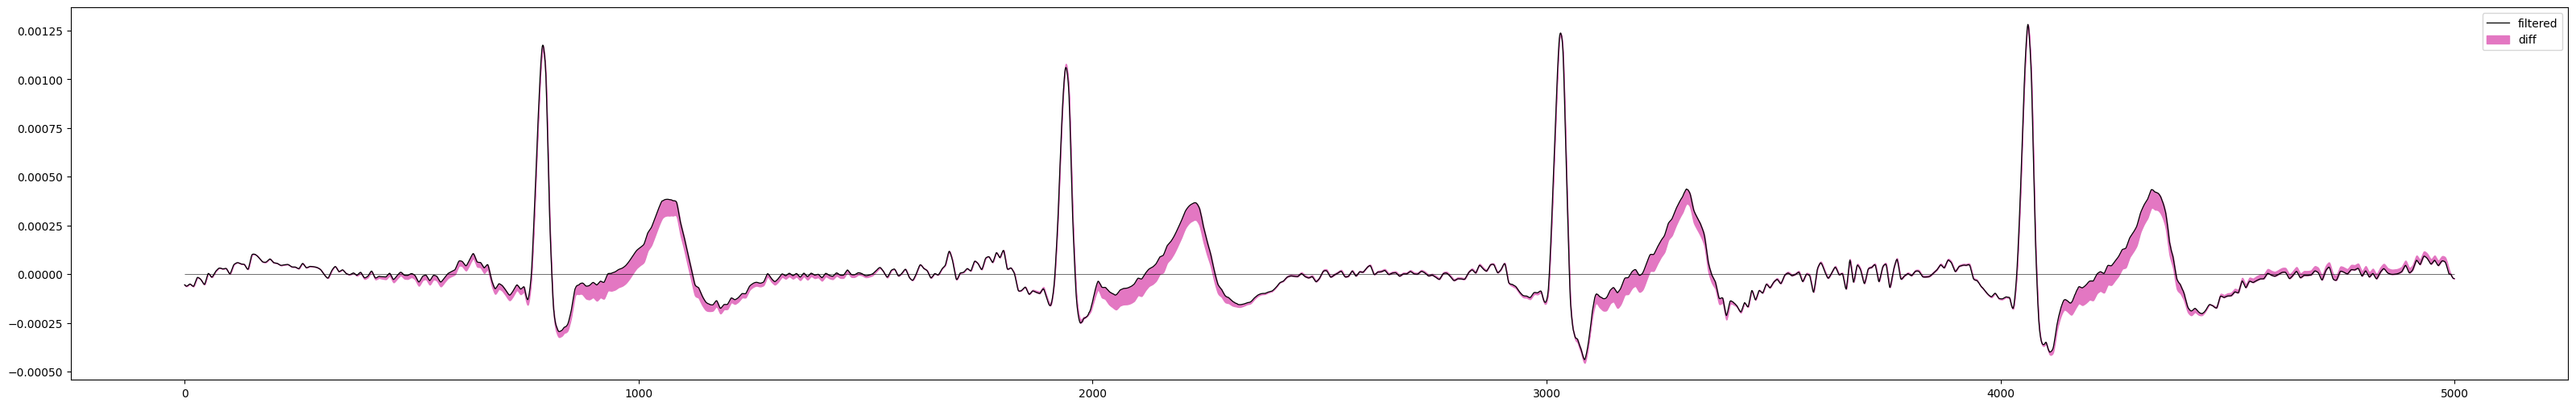

In [14]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(1000, ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0



signal_flt = filter_signal(signal_den)
plt.figure(figsize=(40,6))

plt.plot(signal_den, color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.fill_between(np.arange(0,5000,1),signal_den,signal_flt,color='tab:pink',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

## Difference

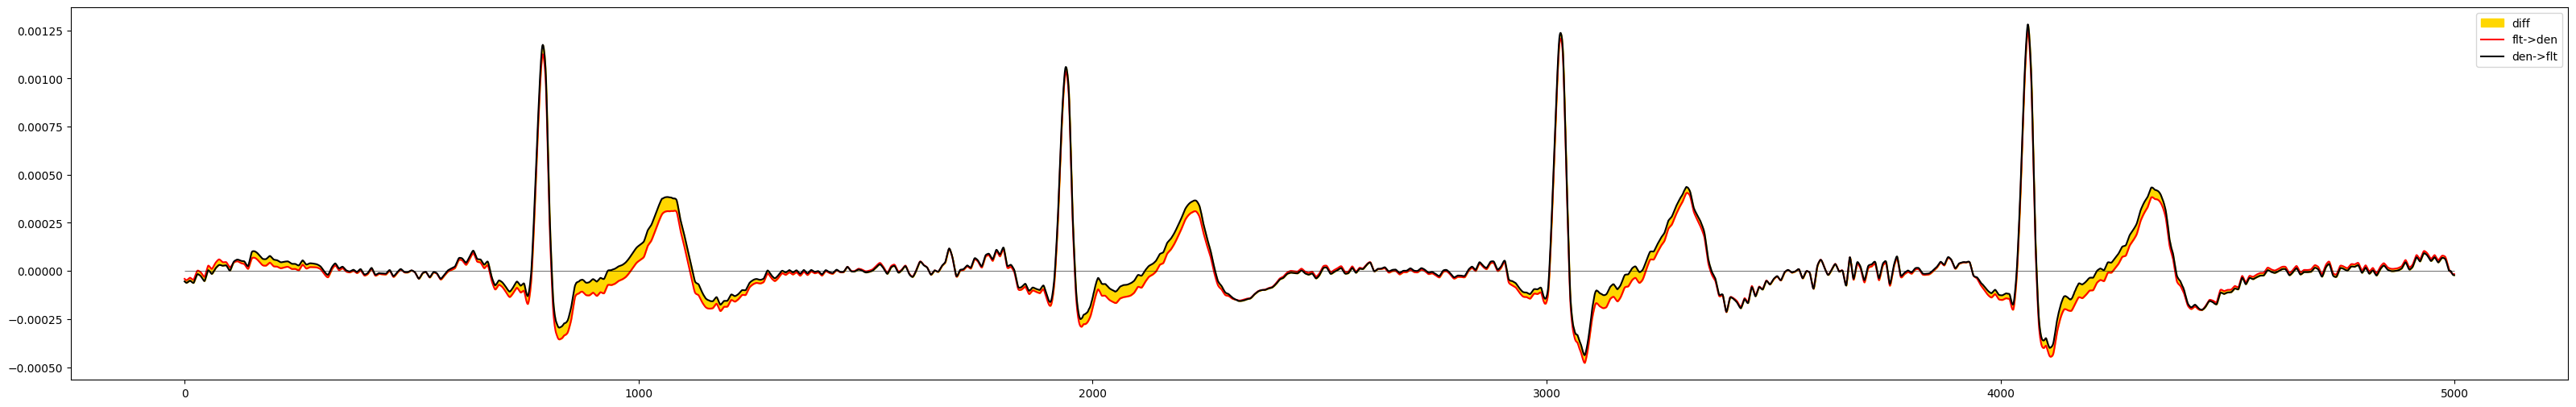

In [15]:
s1 = denoise_signal(filter_signal(sample),'bior4.4', 9 , 1 , 7) # first filtered then denoised
s2 = filter_signal(denoise_signal(sample,'bior4.4', 9 , 1 , 7)) #first denoised then filtered

plt.figure(figsize=(40,6))

plt.fill_between(np.arange(0,5000,1),s1,s2,color='gold',label = 'diff')
plt.plot(s1, color='red',label = 'flt->den')
plt.plot(s2, color='black',label = 'den->flt')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

## R-Peak Detection

In [16]:
from ecgdetectors import Detectors
detectors = Detectors(1000) # hz

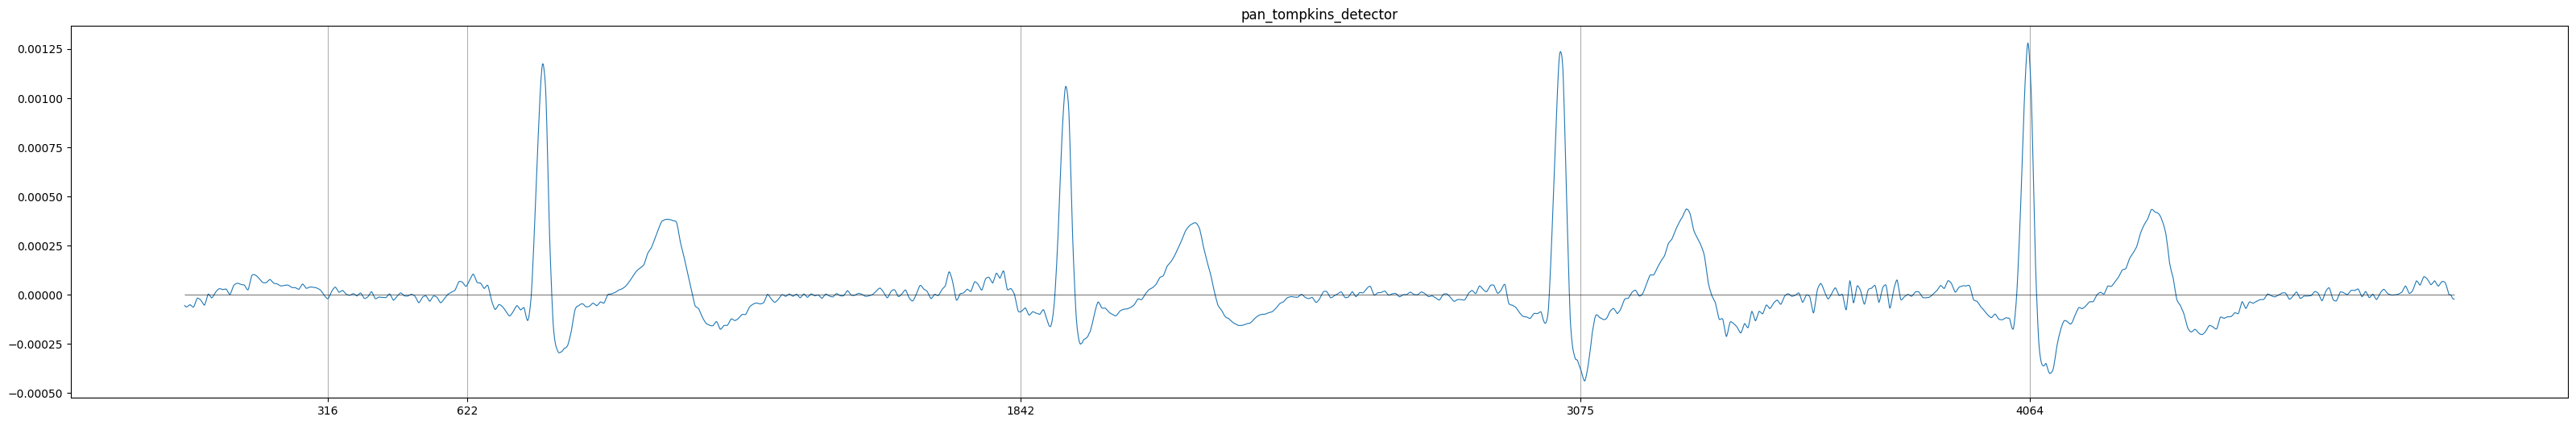

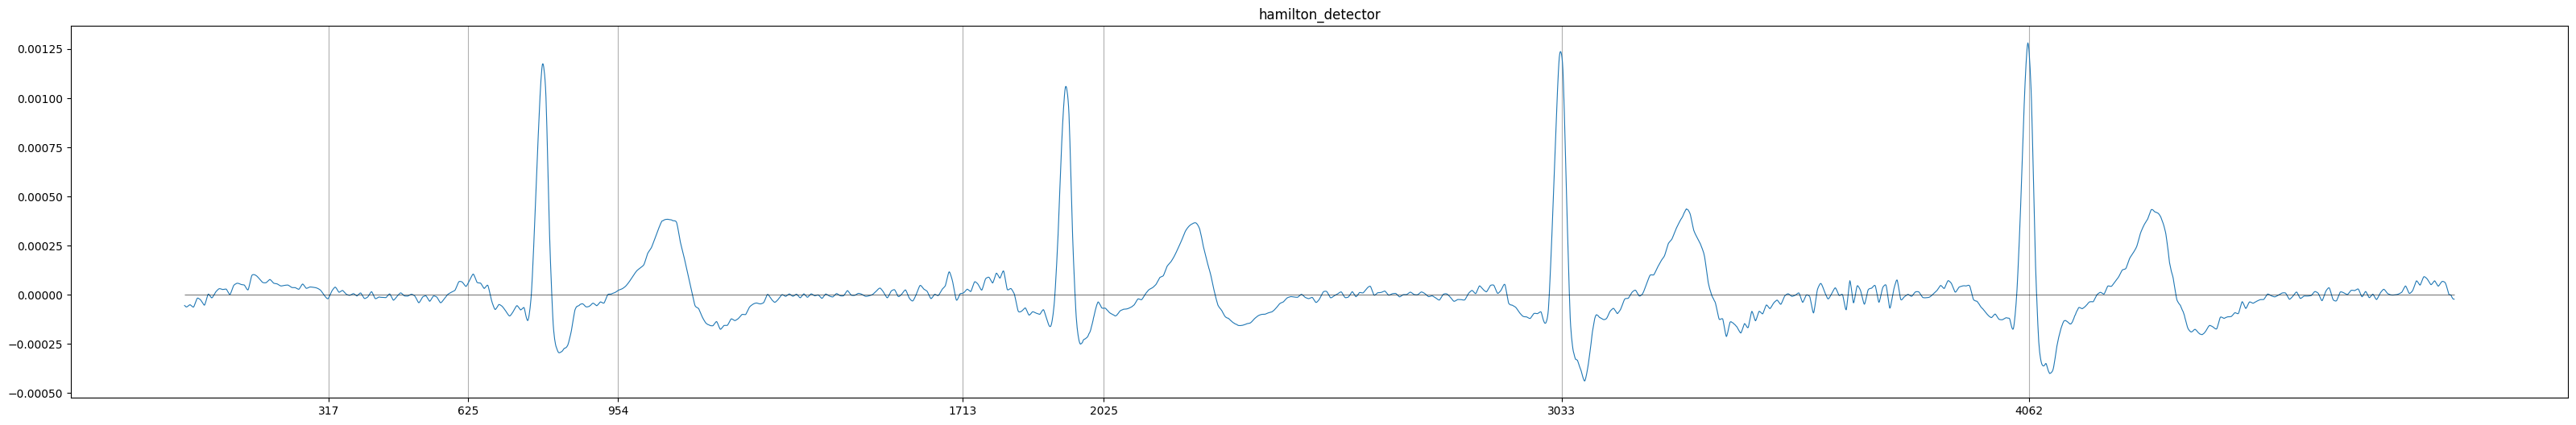

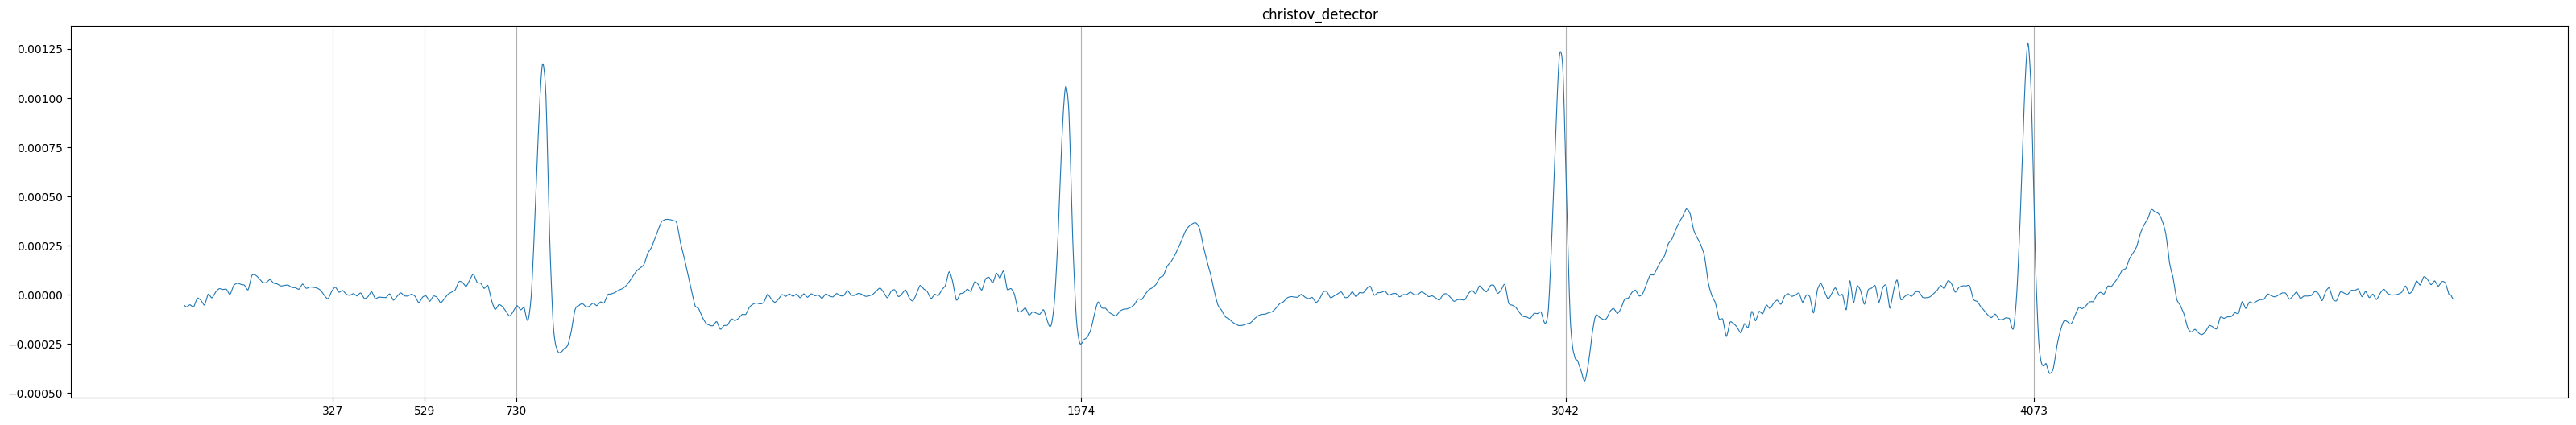

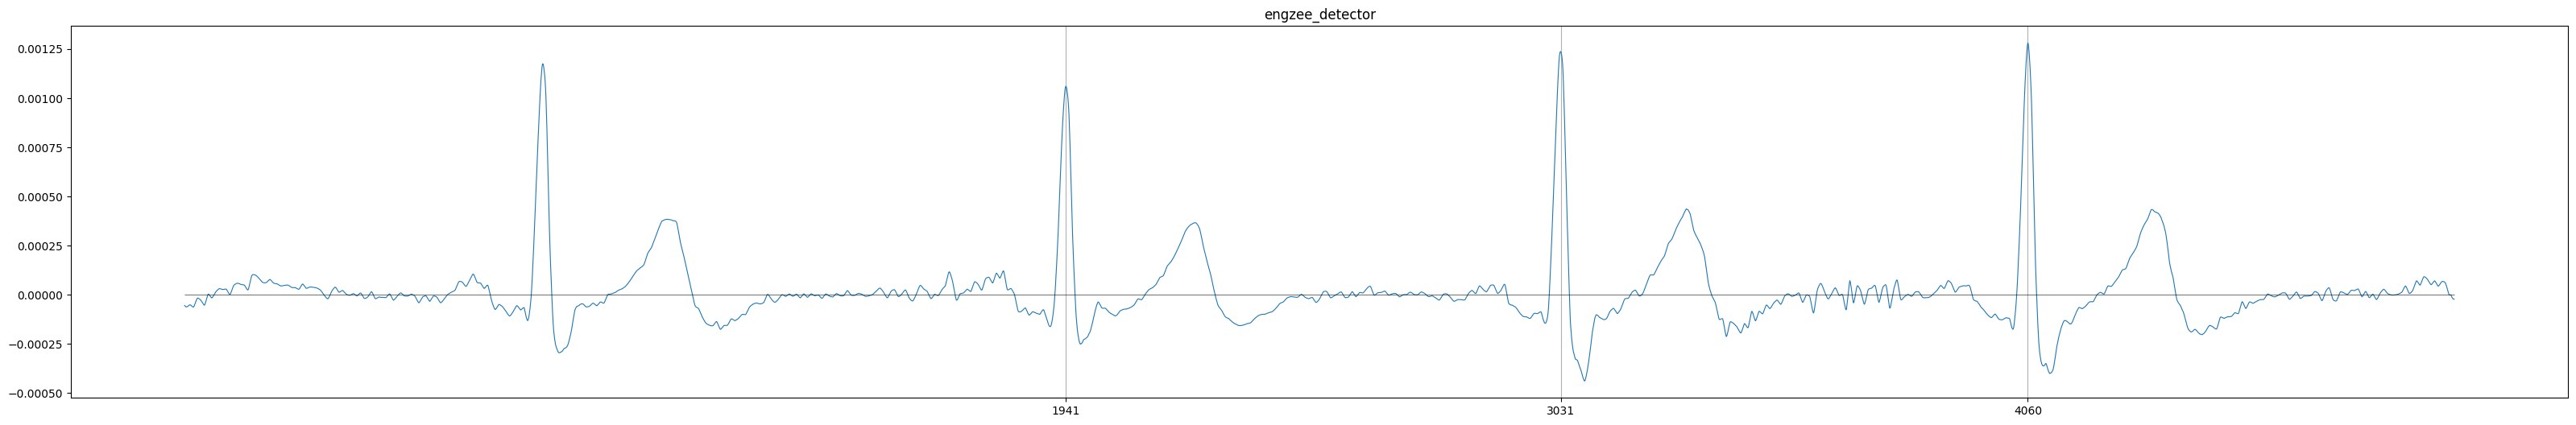

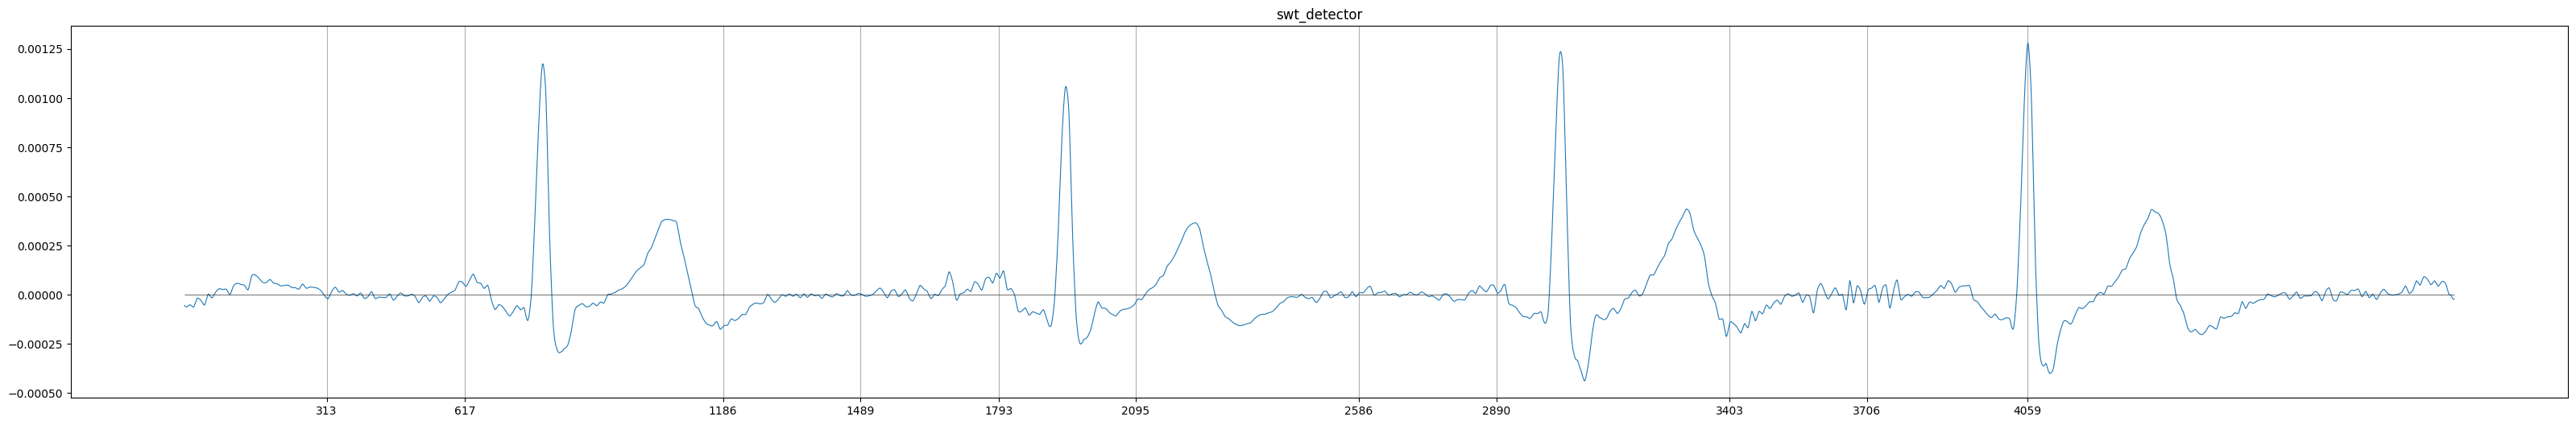

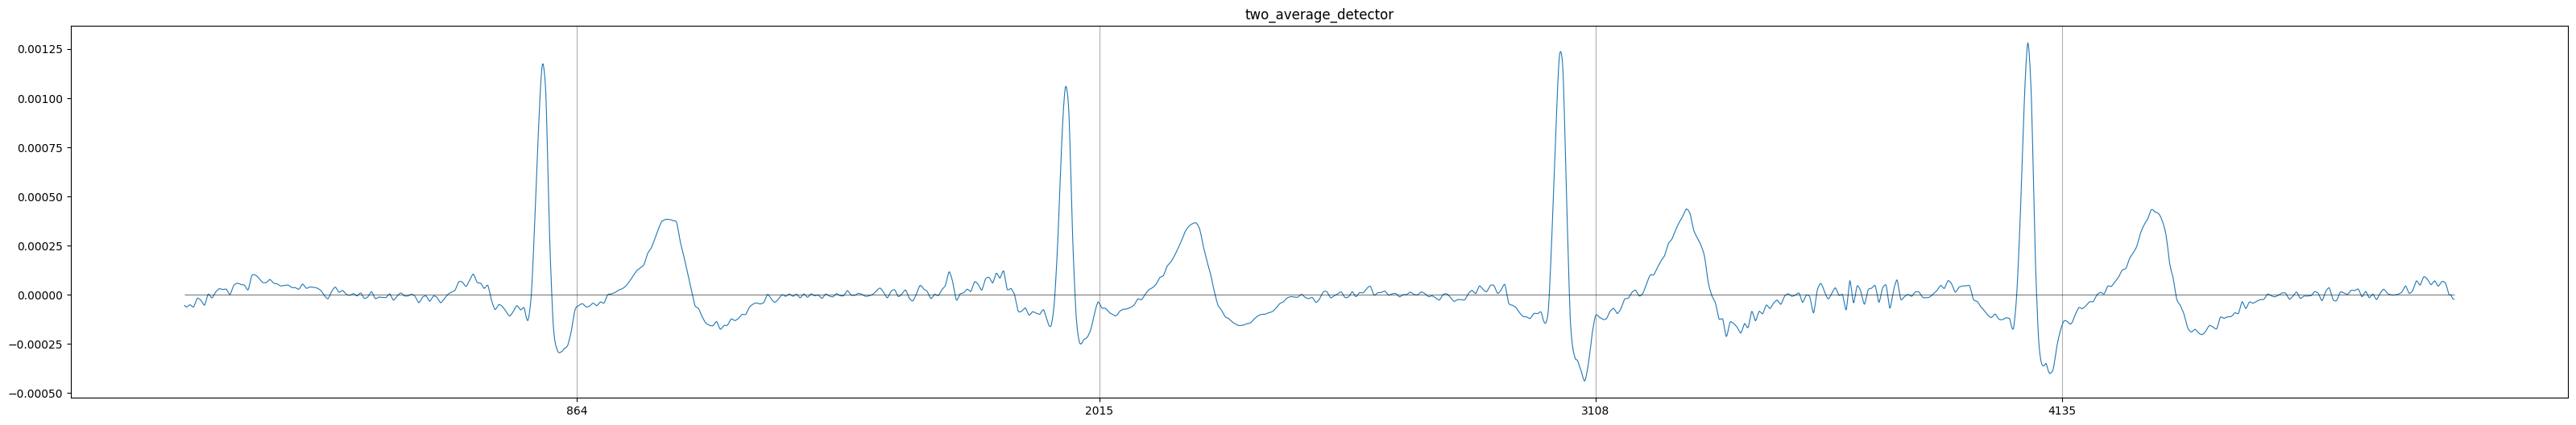

In [17]:
signal_pad_samples = 10
signal_pad = np.zeros(signal_pad_samples) # pad one sec to detect initial peaks properly
signalf = signal_flt

detectors = {
    'pan_tompkins_detector':[detectors.pan_tompkins_detector, []],
    'hamilton_detector':[detectors.hamilton_detector, []],
    'christov_detector':[detectors.christov_detector, []],
    'engzee_detector':[detectors.engzee_detector, []],
    'swt_detector':[detectors.swt_detector, []],
    'two_average_detector':[detectors.two_average_detector, []],
}


for kd in detectors.keys():
    vd = detectors[kd]
    r_peaks = np.array(vd[0](np.hstack((signal_pad,signal_flt)))) - signal_pad_samples
    vd[1] = r_peaks
    plt.figure(figsize=(40,6))
    plt.title(kd)
    plt.plot(signalf,color='tab:blue',linewidth=0.8)
    plt.hlines(0,0,5000,color='black', linewidth=0.4)
    plt.xticks(r_peaks)
    plt.grid(axis='x')
    plt.show()